<a href="https://colab.research.google.com/github/dinoanasta/English-To-isiZulu/blob/main/English_To_isiZulu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English to isiZulu Machine Translation
## COMS4054A - Natural Language Processing
### Group Members:
Jesse Bristow (1875955)<br>
Chloë Smith (1877342)<br>
Dino Anastasopoulos (1900661)<br>


# Setup and Imports

In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 54.6 MB/s 
     |████████████████████████████████| 3.3 MB 55.0 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import collections
from collections import defaultdict

import helper
import numpy as np
import pandas as pd
import math
import os
import cv2
import random
import skimage
from skimage.color import rgb2gray
from skimage import img_as_float
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
#from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

from tokenizers import Tokenizer as Toke
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from nltk.translate.bleu_score import corpus_bleu


# Data Ingestion and Preprocessing

In [3]:
!wget https://zenodo.org/record/5035171/files/en-zu.eval.csv
!wget https://zenodo.org/record/5035171/files/en-zu.training.csv

--2021-11-25 08:32:09--  https://zenodo.org/record/5035171/files/en-zu.eval.csv
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466677 (456K) [text/plain]
Saving to: ‘en-zu.eval.csv’

en-zu.eval.csv      100%[===================>] 455.74K   239KB/s    in 1.9s    

2021-11-25 08:32:14 (239 KB/s) - ‘en-zu.eval.csv’ saved [466677/466677]

--2021-11-25 08:32:14--  https://zenodo.org/record/5035171/files/en-zu.training.csv
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1529050 (1.5M) [text/plain]
Saving to: ‘en-zu.training.csv’

en-zu.training.csv  100%[===================>]   1.46M   235KB/s    in 6.5s    

2021-11-25 08:32:22 (229 KB/s) - ‘en-zu.training.csv’ saved [1529050/1529050]



In [4]:
df_train = pd.read_csv('en-zu.training.csv')
print(df_train.head(3).columns)
df_eval = pd.read_csv('en-zu.eval.csv')
print(df_eval.head(3).columns)

Index(['en', 'zu', 'source'], dtype='object')
Index(['en', 'zu', 'zu.1', 'Source'], dtype='object')


In [5]:
print(df_train['en'], df_train['zu'])
english_sentences = df_train['en']
zulu_sentences = df_train['zu']

for i in range(len(english_sentences)):
  english_sentences[i] = english_sentences[i].lower()
  zulu_sentences[i] = zulu_sentences[i].lower()

0       His solo albums in the 60s were some of the mo...
1       From which it follows that if you want to save...
2       Thirty years after St. John Paul II begged Moz...
3       Wynford yw sylfaenydd Stafell Fyw yng Nghaerdy...
4       Unai Emery's side have won just two of their l...
                              ...                        
4734    The picture shows the infant breastfeeding whi...
4735    Blame the producers, who constantly switch and...
4736                              (Javier Garcia/BPI/REX)
4737    "I have enormous respect for Laura, She does a...
4738    But despite the chaotic circumstances of the s...
Name: en, Length: 4739, dtype: object 0       Ama-albhamu akhe e-solo eminyaka yawo-60 angam...
1       Ukusuka lapho kuzobe sekulandela ukuthi uma uf...
2       Ngemuva kweminyaka engamashumi amathathu u-St....
3       Wynford yw sylfaenydd Stafell Fyw yng Nghaerdy...
4       Iqembu lika-Unai Emery lisanqobe imidlalo emib...
                              ... 

In [6]:
# BPETokenizer training
english_vocab_size_bpe = 10000
zulu_vocab_size_bpe = 10000

tokenizer_en = Toke(BPE(unk_token="[UNK]"))
tokenizer_zu = Toke(BPE(unk_token="[UNK]"))

trainer_en = BpeTrainer(vocab_size = english_vocab_size_bpe, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
trainer_zu = BpeTrainer(vocab_size = zulu_vocab_size_bpe, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

tokenizer_en.pre_tokenizer = Whitespace()
tokenizer_zu.pre_tokenizer = Whitespace()

#files = [f"data/wikitext-103-raw/wiki.{split}.raw" for split in ["test", "train", "valid"]]
tokenizer_en.train_from_iterator(english_sentences, trainer_en)
tokenizer_zu.train_from_iterator(zulu_sentences, trainer_zu)

output = tokenizer_en.encode(("Hello, y'all! How are you 😁 ?").lower())
output1 = tokenizer_en.encode(("abukho ubuholi obungasusa abaphikisana nama-semites.").lower())
print(output.tokens)
print(output1.tokens)
outputz = tokenizer_zu.encode(("Hello, y'all! How are you 😁 ?").lower())
outputz1 = tokenizer_zu.encode(("abukho ubuholi obungasusa abaphikisana nama-semites.").lower())
print(outputz.tokens)
print(outputz1.tokens)
print(tokenizer_en.token_to_id("hel"))
print(tokenizer_en.id_to_token(1))

['hello', ',', 'y', "'", 'all', '!', 'how', 'are', 'you', '[UNK]', '?']
['ab', 'uk', 'ho', 'u', 'bu', 'hol', 'i', 'ob', 'un', 'gas', 'usa', 'ab', 'ap', 'hik', 'is', 'ana', 'nam', 'a', '-', 'semit', 'es', '.']
['hel', 'lo', ',', 'y', "'", 'all', '!', 'ho', 'w', 'are', 'you', '[UNK]', '?']
['abukho', 'ubuholi', 'obunga', 'susa', 'abaphikisana', 'nama', '-', 'semi', 'tes', '.']
511
[CLS]


In [7]:
# Remove empty rows and maybe rows that have sequences of length longer than x
length_counts_en = defaultdict(lambda: 0)
length_counts_zu = defaultdict(lambda: 0)
inds_to_remove = []
for i in range(len(english_sentences)):
  length_counts_en[len(english_sentences[i].split())] += 1
  length_counts_zu[len(zulu_sentences[i].split())] += 1
  if len(english_sentences[i].split()) > 20 or len(zulu_sentences[i].split()) > 20:
    inds_to_remove.append(i)

old_eng_sent = english_sentences
old_zu_sent = zulu_sentences
english_sentences = english_sentences.drop(inds_to_remove, axis=0)
zulu_sentences = zulu_sentences.drop(inds_to_remove, axis=0)

english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
zulu_words_counter = collections.Counter([word for sentence in zulu_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} Zulu words.'.format(len([word for sentence in zulu_sentences for word in sentence.split()])))
print('{} unique Zulu words.'.format(len(zulu_words_counter)))
print('10 Most common words in the Zulu dataset:')
print('"' + '" "'.join(list(zip(*zulu_words_counter.most_common(10)))[0]) + '"')

27271 English words.
9538 unique English words.
10 Most common words in the English dataset:
"the" "to" "a" "and" "in" "of" "is" "for" "was" "on"

21288 Zulu words.
14241 unique Zulu words.
10 Most common words in the Zulu dataset:
"ukuthi" "futhi" "kakhulu" "noma" "kodwa" "uma" "kusho" "kanye" "-" "kube"


# Functions

In [8]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

def bpe_tokenize(x, tokenizer_to_use):
  # return the bpe tokenization of each sentence as a sequence
  all_seq = []
  for curr_sent in x:
    otp = tokenizer_to_use.encode(curr_sent)
    curr_tokenization = otp.tokens
    curr_seq = []
    for curr_token in curr_tokenization:
      curr_seq.append(tokenizer_to_use.token_to_id(curr_token))

    all_seq.append(curr_seq)
  
  return all_seq

In [9]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

In [10]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x_bpe = bpe_tokenize(x, tokenizer_en)
    preprocess_y_bpe = bpe_tokenize(y, tokenizer_zu)

    #Print min and max values of zulu sentences
    min_zu = 2000
    max_zu = 0
    for sample_i, (sent, token_sent) in enumerate(zip(y, preprocess_y_bpe)):
      if len(token_sent) != 0:
        min_zu = min(min_zu, min(token_sent))
        max_zu = max(max_zu, max(token_sent))
    print('Min:', min_zu, ' Max:', max_zu)


    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_x_bpe = pad(preprocess_x_bpe)
    preprocess_y_bpe = pad(preprocess_y_bpe)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    preprocess_y_bpe = preprocess_y_bpe.reshape(*preprocess_y_bpe.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk, preprocess_x_bpe, preprocess_y_bpe

preproc_english_sentences, preproc_zulu_sentences, english_tokenizer, zulu_tokenizer, preproc_english_sentences_bpe, preproc_zulu_sentences_bpe =\
    preprocess(english_sentences, zulu_sentences)
    
preproc_english_sentences_test = preproc_english_sentences[int(0.9*len(preproc_english_sentences)):]
preproc_zulu_sentences_test = preproc_zulu_sentences[int(0.9*len(preproc_zulu_sentences)):]
preproc_english_sentences = preproc_english_sentences[:int(0.9*len(preproc_english_sentences))]
preproc_zulu_sentences = preproc_zulu_sentences[:int(0.9*len(preproc_zulu_sentences))]

preproc_english_sentences_test_bpe = preproc_english_sentences_bpe[int(0.9*len(preproc_english_sentences_bpe)):]
preproc_zulu_sentences_test_bpe = preproc_zulu_sentences_bpe[int(0.9*len(preproc_zulu_sentences_bpe)):]
preproc_english_sentences_bpe = preproc_english_sentences_bpe[:int(0.9*len(preproc_english_sentences_bpe))]
preproc_zulu_sentences_bpe = preproc_zulu_sentences_bpe[:int(0.9*len(preproc_zulu_sentences_bpe))]

max_english_sequence_length = preproc_english_sentences.shape[1]
max_zulu_sequence_length = preproc_zulu_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
zulu_vocab_size = len(zulu_tokenizer.word_index)

max_english_sequence_length_bpe = preproc_english_sentences_bpe.shape[1]
max_zulu_sequence_length_bpe = preproc_zulu_sentences_bpe.shape[1]

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max Zulu sentence length:", max_zulu_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("Zulu vocabulary size:", zulu_vocab_size)

print()
print("Max English sentence length(bpe):", max_english_sequence_length_bpe)
print("Max Zulu sentence length(bpe):", max_zulu_sequence_length_bpe)
print("English vocabulary size(bpe):", english_vocab_size_bpe)
print("Zulu vocabulary size(bpe):", zulu_vocab_size_bpe)

Min: 5  Max: 9998
Data Preprocessed
Max English sentence length: 23
Max Zulu sentence length: 25
English vocabulary size: 7639
Zulu vocabulary size: 12597

Max English sentence length(bpe): 42
Max Zulu sentence length(bpe): 58
English vocabulary size(bpe): 10000
Zulu vocabulary size(bpe): 10000


In [13]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    #print("ITW:", index_to_words)
    #print("ITW[42]:", index_to_words[42])
    # print(logits, np.shape(logits))
    #print([index_to_words[prediction[0]] for prediction in logits])
    # print([prediction for prediction in np.argmax(logits, 1)])

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
    #return ' '.join([index_to_words[prediction[0]] for prediction in logits])


print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [14]:
def logits_to_seq(logits):
    return [prediction for prediction in np.argmax(logits, 1)]

In [15]:
def logits_to_text_bpe(logits, tokenizer):
  #return ' '.join([tokenizer.id_to_token(prediction) for prediction in logits])
  return ' '.join([tokenizer.id_to_token(prediction) for prediction in np.argmax(logits, 1)])

#   print(preproc_english_sentences_bpe[0])
# print(logits_to_text_bpe(preproc_english_sentences_bpe[0], tokenizer_en))

In [90]:
def calc_bleu_score(references, candidates):
  score = corpus_bleu(references, candidates) # References are the labels, and candidates are the predictions 
  return score

In [17]:
def get_ref_cand(data_to_make_predictions, model, out_labels):
  refs = []
  cands = []
  for i in range(len(data_to_make_predictions)):
    refs.append(np.expand_dims(np.squeeze(out_labels[i], 1), axis=0))
    cands.append(np.array(logits_to_seq(model.predict(data_to_make_predictions[i:i+1])[0])))

  refs = np.array(refs)
  cands = np.array(cands)
  return refs, cands

# Models

### Model 1 - Simple RNN

In [19]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, zulu_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param zulu_vocab_size: Number of unique zulu words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(zulu_vocab_size+1, activation='softmax'))) 
    #model.add(TimeDistributed(Dense(2500, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])
    return model



In [20]:
#tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_zulu_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_zulu_sentences.shape[-2], 1))
tmp_x_test = pad(preproc_english_sentences_test, max_zulu_sequence_length)
tmp_x_test = tmp_x_test.reshape((-1, preproc_zulu_sentences.shape[-2], 1))

#print('Tmp_x', tmp_x[0], np.shape(tmp_x))
#print(logits_to_text(tmp_x[0], english_tokenizer))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_zulu_sequence_length,
    english_vocab_size,
    zulu_vocab_size)

print(simple_rnn_model.summary())

model1 = simple_rnn_model.fit(tmp_x, preproc_zulu_sentences, batch_size=1024, epochs=100, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], zulu_tokenizer))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 25, 256)           198912    
                                                                 
 time_distributed (TimeDistr  (None, 25, 1024)         263168    
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 25, 1024)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 25, 12598)        12912950  
 tributed)                                                       
                                                                 
Total params: 13,375,030
Trainable params: 13,375,030
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2/2 [======================

## Model 2 -Simple RNN with BPE

In [21]:
#tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x_bpe = pad(preproc_english_sentences_bpe, max_zulu_sequence_length_bpe)
tmp_x_bpe = tmp_x_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2], 1))
tmp_x_test_bpe = pad(preproc_english_sentences_test_bpe, max_zulu_sequence_length_bpe)
tmp_x_test_bpe = tmp_x_test_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2], 1))

#print('Tmp_x', tmp_x[0], np.shape(tmp_x))
#print(logits_to_text(tmp_x[0], english_tokenizer))

# Train the neural network
simple_rnn_model_bpe = simple_model(
    tmp_x_bpe.shape,
    max_zulu_sequence_length_bpe,
    english_vocab_size_bpe,
    zulu_vocab_size_bpe)

print(simple_rnn_model_bpe.summary())

model2 = simple_rnn_model_bpe.fit(tmp_x_bpe, preproc_zulu_sentences_bpe, batch_size=1024, epochs=100, validation_split=0.2)

# Print prediction(s)
print(logits_to_text_bpe(simple_rnn_model_bpe.predict(tmp_x_bpe[:1])[0], tokenizer_zu))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 58, 256)           198912    
                                                                 
 time_distributed_2 (TimeDis  (None, 58, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 58, 1024)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 58, 10001)        10251025  
 tributed)                                                       
                                                                 
Total params: 10,713,105
Trainable params: 10,713,105
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2/2 [====================

## Model 3 - RNN with Word Embedding

In [22]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, zulu_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param zulu_vocab_size: Number of unique zulu words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(zulu_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#tests.test_embed_model(embed_model)

# TODO: Reshape the input


In [23]:
tmp_x = pad(preproc_english_sentences, preproc_zulu_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_zulu_sentences.shape[-2]))
tmp_x_test = pad(preproc_english_sentences_test, max_zulu_sequence_length)
tmp_x_test = tmp_x_test.reshape((-1, preproc_zulu_sentences.shape[-2], 1))

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_zulu_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(zulu_tokenizer.word_index)+1)

embed_rnn_model.summary()

model3 = embed_rnn_model.fit(tmp_x, preproc_zulu_sentences, batch_size=1024, epochs=100, validation_split=0.2)

print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], zulu_tokenizer))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 256)           1955840   
                                                                 
 gru_2 (GRU)                 (None, 25, 256)           394752    
                                                                 
 time_distributed_4 (TimeDis  (None, 25, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 25, 1024)          0         
                                                                 
 time_distributed_5 (TimeDis  (None, 25, 12598)        12912950  
 tributed)                                                       
                                                                 
Total params: 15,526,710
Trainable params: 15,526,710


## Model 4 - RNN with Word Embedding and BPE

In [24]:
tmp_x_bpe = pad(preproc_english_sentences_bpe, preproc_zulu_sentences_bpe.shape[1])
tmp_x_bpe = tmp_x_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2]))
tmp_x_test_bpe = pad(preproc_english_sentences_test_bpe, max_zulu_sequence_length_bpe)
tmp_x_test_bpe = tmp_x_test_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2], 1))

# TODO: Train the neural network
embed_rnn_model_bpe = embed_model(
    tmp_x_bpe.shape,
    preproc_zulu_sentences_bpe.shape[1],
    english_vocab_size_bpe+1,
    zulu_vocab_size_bpe+1)

embed_rnn_model_bpe.summary()

model4 = embed_rnn_model_bpe.fit(tmp_x_bpe, preproc_zulu_sentences_bpe, batch_size=1024, epochs=100, validation_split=0.2)

# TODO: Print prediction(s)
print(logits_to_text_bpe(embed_rnn_model_bpe.predict(tmp_x_bpe[:1])[0], tokenizer_zu))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 58, 256)           2560256   
                                                                 
 gru_3 (GRU)                 (None, 58, 256)           394752    
                                                                 
 time_distributed_6 (TimeDis  (None, 58, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 58, 1024)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 58, 10001)        10251025  
 tributed)                                                       
                                                                 
Total params: 13,469,201
Trainable params: 13,469,201


## Model 5 - Bidirectional RNN

In [25]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, zulu_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param zulu_vocab_size: Number of unique zulu words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(zulu_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])
    return model



In [26]:
#tests.test_bd_model(bd_model)

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_zulu_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_zulu_sentences.shape[-2]))
tmp_x_test = pad(preproc_english_sentences_test, max_zulu_sequence_length)
tmp_x_test = tmp_x_test.reshape((-1, preproc_zulu_sentences.shape[-2], 1))


# TODO: Train and Print prediction(s)
embed_rnn_model1 = bd_model(
    tmp_x.shape,
    preproc_zulu_sentences.shape[1],
    english_vocab_size+1,
    zulu_vocab_size+1)

embed_rnn_model1.summary()

model5 = embed_rnn_model1.fit(tmp_x, preproc_zulu_sentences, batch_size=1024, epochs=100, validation_split=0.2)

print(logits_to_text(embed_rnn_model1.predict(tmp_x[:1])[0], zulu_tokenizer))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 256)           1955840   
                                                                 
 bidirectional (Bidirectiona  (None, 25, 256)          296448    
 l)                                                              
                                                                 
 time_distributed_8 (TimeDis  (None, 25, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_4 (Dropout)         (None, 25, 1024)          0         
                                                                 
 time_distributed_9 (TimeDis  (None, 25, 12598)        12912950  
 tributed)                                                       
                                                      

## Model 6 - Bidirectional RNN with BPE

In [27]:
tmp_x_bpe = pad(preproc_english_sentences_bpe, preproc_zulu_sentences_bpe.shape[1])
tmp_x_bpe = tmp_x_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2]))
tmp_x_test_bpe = pad(preproc_english_sentences_test_bpe, max_zulu_sequence_length_bpe)
tmp_x_test_bpe = tmp_x_test_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2], 1))


# TODO: Train and Print prediction(s)
embed_rnn_model1_bpe = bd_model(
    tmp_x_bpe.shape,
    preproc_zulu_sentences_bpe.shape[1],
    english_vocab_size_bpe+1,
    zulu_vocab_size_bpe+1)

embed_rnn_model1_bpe.summary()

model6 = embed_rnn_model1_bpe.fit(tmp_x_bpe, preproc_zulu_sentences_bpe, batch_size=1024, epochs=100, validation_split=0.2)

print(logits_to_text_bpe(embed_rnn_model1_bpe.predict(tmp_x_bpe[:1])[0], tokenizer_zu))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 58, 256)           2560256   
                                                                 
 bidirectional_1 (Bidirectio  (None, 58, 256)          296448    
 nal)                                                            
                                                                 
 time_distributed_10 (TimeDi  (None, 58, 1024)         263168    
 stributed)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 58, 1024)          0         
                                                                 
 time_distributed_11 (TimeDi  (None, 58, 10001)        10251025  
 stributed)                                                      
                                                      

## Model 7 - Bidirectional RNN with Word Embedding, Encoder-Decoder and Standard Tokenization

In [65]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, zulu_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param zulu_vocab_size: Number of unique zulu words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    
    # Hyperparameters
    learning_rate = 0.001
    
    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    
    # Encoder
    model.add(Bidirectional(GRU(128), input_shape=input_shape[1:]))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(zulu_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In [66]:
tmp_x = pad(preproc_english_sentences, preproc_zulu_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_zulu_sentences.shape[-2]))
tmp_x_test = pad(preproc_english_sentences_test, max_zulu_sequence_length)
tmp_x_test = tmp_x_test.reshape((-1, preproc_zulu_sentences.shape[-2], 1))


# TODO: Train and Print prediction(s)
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    preproc_zulu_sentences.shape[1],
    english_vocab_size+1,
    zulu_vocab_size+1)

encdec_rnn_model.summary()

model7 = encdec_rnn_model.fit(tmp_x, preproc_zulu_sentences, batch_size=1024, epochs=100, validation_split=0.2)


print(logits_to_text(encdec_rnn_model.predict(tmp_x[:1])[0], zulu_tokenizer))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 25, 256)           1955840   
                                                                 
 bidirectional_10 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 repeat_vector_4 (RepeatVect  (None, 25, 256)          0         
 or)                                                             
                                                                 
 bidirectional_11 (Bidirecti  (None, 25, 256)          296448    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 25, 1024)         263168    
 stributed)                                          

## Model 8 - Bidirectional RNN with Word Embedding, Encoder-Decoder and BPE

In [67]:
tmp_x_bpe = pad(preproc_english_sentences_bpe, preproc_zulu_sentences_bpe.shape[1])
tmp_x_bpe = tmp_x_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2]))
tmp_x_test_bpe = pad(preproc_english_sentences_test_bpe, max_zulu_sequence_length_bpe)
tmp_x_test_bpe = tmp_x_test_bpe.reshape((-1, preproc_zulu_sentences_bpe.shape[-2], 1))


# TODO: Train and Print prediction(s)
encdec_rnn_model_bpe = encdec_model(
    tmp_x_bpe.shape,
    preproc_zulu_sentences_bpe.shape[1],
    english_vocab_size_bpe+1,
    zulu_vocab_size_bpe+1)

encdec_rnn_model_bpe.summary()

model8 = encdec_rnn_model_bpe.fit(tmp_x_bpe, preproc_zulu_sentences_bpe, batch_size=1024, epochs=100, validation_split=0.2)

print(logits_to_text_bpe(encdec_rnn_model_bpe.predict(tmp_x_bpe[:1])[0], tokenizer_zu))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 58, 256)           2560256   
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 repeat_vector_5 (RepeatVect  (None, 58, 256)          0         
 or)                                                             
                                                                 
 bidirectional_13 (Bidirecti  (None, 58, 256)          296448    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 58, 1024)         263168    
 stributed)                                          

# Testing and Analysis

## Model 1 BLEU score

In [91]:
ref, cand = get_ref_cand(tmp_x_test, simple_rnn_model, preproc_zulu_sentences_test)
model1_bleu = calc_bleu_score(ref, cand)
print('Model 1 BLEU Score: ', model1_bleu)

Model 1 BLEU Score:  0.5438605119768107


## Model 2 BLEU score

In [92]:
ref, cand = get_ref_cand(tmp_x_test_bpe, simple_rnn_model_bpe, preproc_zulu_sentences_test_bpe)
model2_bleu = calc_bleu_score(ref, cand)
print('Model 2 BLEU Score: ', model2_bleu)

Model 2 BLEU Score:  0.6617693528647335


## Model 3 BLEU score

In [93]:
ref, cand = get_ref_cand(tmp_x_test, embed_rnn_model, preproc_zulu_sentences_test)
model3_bleu = calc_bleu_score(ref, cand)
print('Model 3 BLEU Score: ', model3_bleu)

Model 3 BLEU Score:  0.5204408753320908


## Model 4 BLEU score

In [94]:
ref, cand = get_ref_cand(tmp_x_test_bpe, embed_rnn_model_bpe, preproc_zulu_sentences_test_bpe)
model4_bleu = calc_bleu_score(ref, cand)
print('Model 4 BLEU Score: ', model4_bleu)

Model 4 BLEU Score:  0.6569147694211473


## Model 5 BLEU score

In [95]:

ref, cand = get_ref_cand(tmp_x_test, embed_rnn_model1, preproc_zulu_sentences_test)
model5_bleu = calc_bleu_score(ref, cand)
print('Model 5 BLEU Score: ', model5_bleu)

Model 5 BLEU Score:  0.5291836999481887


## Model 6 BLEU score

In [96]:
ref, cand = get_ref_cand(tmp_x_test_bpe, embed_rnn_model1_bpe, preproc_zulu_sentences_test_bpe)
model6_bleu = calc_bleu_score(ref, cand)
print('Model 6 BLEU Score: ', model6_bleu)

Model 6 BLEU Score:  0.6602372661411107


## Model 7 BLEU score

In [97]:
ref, cand = get_ref_cand(tmp_x_test, encdec_rnn_model, preproc_zulu_sentences_test)
model7_bleu = calc_bleu_score(ref, cand)
print('Model 7 BLEU Score: ', model7_bleu)

Model 7 BLEU Score:  0.5446390470979747


## Model 8 BLEU score

In [98]:
ref, cand = get_ref_cand(tmp_x_test_bpe, encdec_rnn_model_bpe, preproc_zulu_sentences_test_bpe)
model8_bleu = calc_bleu_score(ref, cand)
print('Model 8 BLEU Score: ', model8_bleu)

Model 8 BLEU Score:  0.657228153670047


## BLEU Score Plots

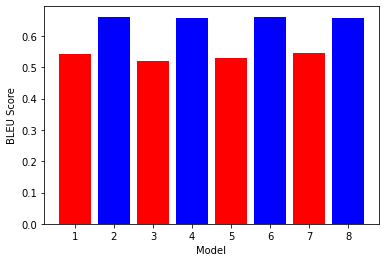

In [89]:
models = ['1', '2', '3', '4', '5', '6', '7', '8', ]
scores = [model1_bleu, model2_bleu, model3_bleu, model4_bleu, model5_bleu, model6_bleu, model7_bleu, model8_bleu]
plt.bar(models,scores, color=["red", "blue"])
plt.xlabel("Model")
plt.ylabel("BLEU Score")
plt.show()

# Plots

In [74]:
import matplotlib.pyplot as plt

In [75]:

train_loss1 = model1.history['loss']
val_loss1   = model1.history['val_loss']
train_acc1  = model1.history['accuracy']
val_acc1    = model1.history['val_accuracy']


train_loss2 = model2.history['loss']
val_loss2   = model2.history['val_loss']
train_acc2  = model2.history['accuracy']
val_acc2    = model2.history['val_accuracy']


train_loss3 = model3.history['loss']
val_loss3   = model3.history['val_loss']
train_acc3  = model3.history['accuracy']
val_acc3    = model3.history['val_accuracy']


train_loss4 = model4.history['loss']
val_loss4   = model4.history['val_loss']
train_acc4  = model4.history['accuracy']
val_acc4    = model4.history['val_accuracy']


train_loss5 = model5.history['loss']
val_loss5   = model5.history['val_loss']
train_acc5  = model5.history['accuracy']
val_acc5    = model5.history['val_accuracy']


train_loss6 = model6.history['loss']
val_loss6   = model6.history['val_loss']
train_acc6  = model6.history['accuracy']
val_acc6    = model6.history['val_accuracy']


train_loss7 = model7.history['loss']
val_loss7   = model7.history['val_loss']
train_acc7  = model7.history['accuracy']
val_acc7    = model7.history['val_accuracy']

train_loss8 = model8.history['loss']
val_loss8   = model8.history['val_loss']
train_acc8  = model8.history['accuracy']
val_acc8    = model8.history['val_accuracy']

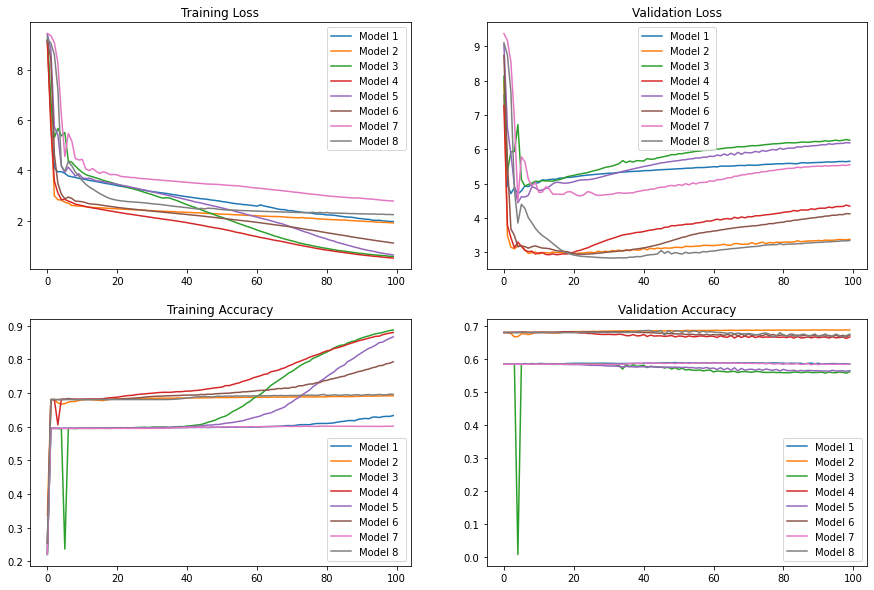

In [77]:
metrics = plt.figure()
metrics.set_figheight(10)
metrics.set_figwidth(15)

xc = range(100)

metrics.add_subplot(2, 2, 1)
plt.title("Training Loss")
plt.plot(xc, train_loss1, label="Model 1 ")
plt.plot(xc, train_loss2, label="Model 2")
plt.plot(xc, train_loss3, label="Model 3")
plt.plot(xc, train_loss4, label="Model 4")
plt.plot(xc, train_loss5, label="Model 5")
plt.plot(xc, train_loss6, label="Model 6")
plt.plot(xc, train_loss7, label="Model 7")
plt.plot(xc, train_loss8, label="Model 8")

plt.legend()
# plt.show()

metrics.add_subplot(2, 2, 2)
plt.title("Validation Loss")
plt.plot(xc, val_loss1, label="Model 1 ")
plt.plot(xc, val_loss2, label="Model 2")
plt.plot(xc, val_loss3, label="Model 3")
plt.plot(xc, val_loss4, label="Model 4")
plt.plot(xc, val_loss5, label="Model 5")
plt.plot(xc, val_loss6, label="Model 6")
plt.plot(xc, val_loss7, label="Model 7")
plt.plot(xc, val_loss8, label="Model 8")

plt.legend()

metrics.add_subplot(2, 2, 3)
plt.title("Training Accuracy")
plt.plot(xc, train_acc1, label="Model 1 ")
plt.plot(xc, train_acc2, label="Model 2")
plt.plot(xc, train_acc3, label="Model 3")
plt.plot(xc, train_acc4, label="Model 4")
plt.plot(xc, train_acc5, label="Model 5")
plt.plot(xc, train_acc6, label="Model 6")
plt.plot(xc, train_acc7, label="Model 7")
plt.plot(xc, train_acc8, label="Model 8")
plt.legend()

metrics.add_subplot(2, 2, 4)
plt.title("Validation Accuracy")
plt.plot(xc, val_acc1, label="Model 1 ")
plt.plot(xc, val_acc2, label="Model 2")
plt.plot(xc, val_acc3, label="Model 3")
plt.plot(xc, val_acc4, label="Model 4")
plt.plot(xc, val_acc5, label="Model 5")
plt.plot(xc, val_acc6, label="Model 6")
plt.plot(xc, val_acc7, label="Model 7")
plt.plot(xc, val_acc8, label="Model 8")

plt.legend()
plt.show()